# Description:
The entire conversion from ADC counts to voltage at the antenna. On top of that, the thermal power noise temperature is computed from some specific runs in this script.

# Importing modules:

In [1]:
#import scipy as sc
import scipy.fft as scfft
#%matplotlib widget

In [2]:
from ThermalFunctions import *

# Converting from ADC to Noise power

Look at data from station 22, run 101, channel 7

In [3]:
CombinedFileSt22R101, DAQStatFileSt22R101, HeadersFileSt22R101, PedestalFileSt22R101=FilesStRun(22,101)
RadiantDataSt22R101=CombinedFileSt22R101['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
EventNrsSt22R101=CombinedFileSt22R101['combined']['waveforms']['event_number'].array(library="np")
PedestalDataSt22R101=PedestalFileSt22R101['']['pedestals[24][4096]'].array(library='np')
StartWindowSt22R101 = np.array(CombinedFileSt22R101['combined']['header/trigger_info/trigger_info.radiant_info.start_windows[24][2]'])
#print(RadiantDataSt11R101.shape) #107 is for events, 24 channels & 2048 for each timestep

St 22 Run 101 is from 2021-07-27 22:32:24.563 until	2021-07-28 00:32:25.030 <br> 
*(Source: DESY run summary)*

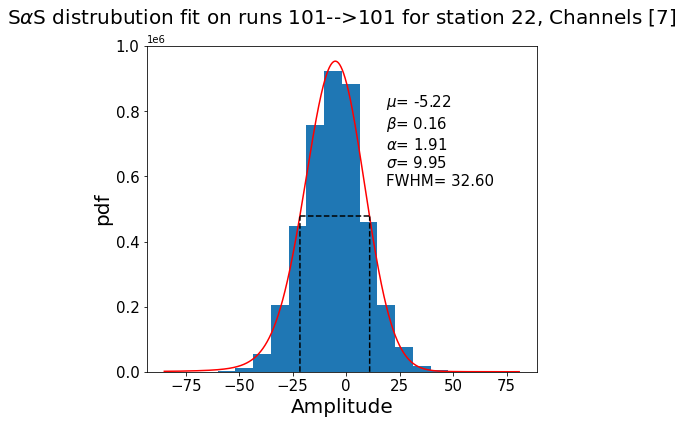

In [4]:
Param,FWHM=SASFitRuns(22,[101],ChNrs=[7],Plot=True)

## Manual tryout for Station 22, Channel 7, Run 101

Visualize the timetrace:

In [5]:
TimeTrace(7,EventNrsSt22R101[5],RadiantDataSt22R101,EventNrsSt22R101)

Compute the FFT of the original timetrace

In [6]:
sampling_rate=3.2 * (10**9) #Sampling rate in Hertz according to the python file of NuRadioReco.modules.io.rno_g
TimeStep=1/sampling_rate #Time between two samples

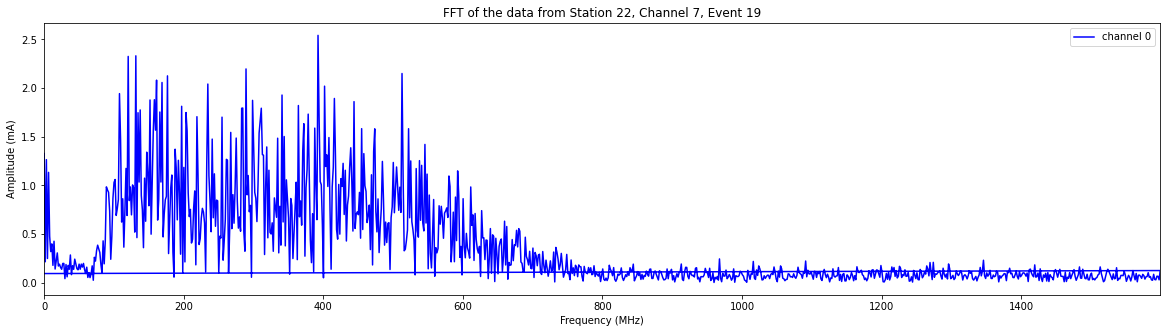

In [7]:
SamplingTimes=np.arange(0,len(RadiantDataSt22R101[5][7])*TimeStep,TimeStep)

FFT=scfft.fft(RadiantDataSt22R101[5][7])
freq=scfft.fftfreq(len(SamplingTimes),(SamplingTimes[-1]-SamplingTimes[0])/len(SamplingTimes))

plt.figure(figsize=(20,5)) #visualization 
plt.plot(freq*(10**-6),(2/len(SamplingTimes))*np.abs(FFT),'-',color='b', label="channel 0") #Convert freq to MHz
plt.title("FFT of the data from Station 22, Channel 7, Event 19")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Amplitude (mA)")
plt.xlim(0,np.max(freq*(10**-6)))
plt.legend()
plt.show()

Convert ADC counts into voltages:

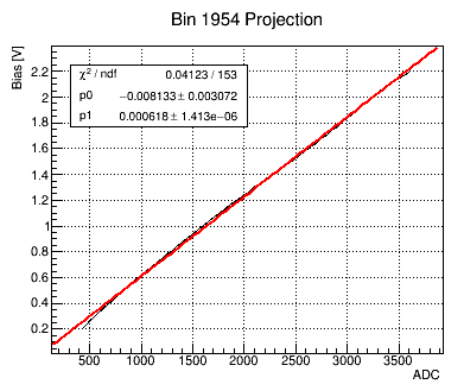

*Lab station at 20C, channel 0*, taken from slides *RNO-G Waveform Calibration* by Cosmin <br>
Slope was similar for other cases in those slides but the offset showed some variation

In [8]:
def ADCtoVoltage(ADCCounts):
    ADC_Factor=0.000618
    ADC_Offset=-0.008133 #Set this to zero for now, otherwise the FFT becomes extremely weird
    return (ADC_Factor*ADCCounts + ADC_Offset)

In [9]:
VRadiantDataSt22R101=ADCtoVoltage(RadiantDataSt22R101)#np.array([ADCtoVoltage(ADC) for ADC in RadiantDataSt22R101])

Plot timetrace of the voltages:

In [10]:
print("Note: the y-axis here is now in Volt instead of the usual ADC counts")
TimeTrace(7,EventNrsSt22R101[5],VRadiantDataSt22R101,EventNrsSt22R101)

Note: the y-axis here is now in Volt instead of the usual ADC counts


Compute FFT of voltages:

In [11]:
VSamplingTimes=np.arange(0,len(VRadiantDataSt22R101[5][7])*TimeStep,TimeStep)

In [12]:
VFFT=scfft.fft(VRadiantDataSt22R101[5][7])
Vfreq=scfft.fftfreq(len(VSamplingTimes),(VSamplingTimes[-1]-VSamplingTimes[0])/len(VSamplingTimes))
print(max((2/len(VSamplingTimes))*np.abs(VFFT)))

0.01544521875


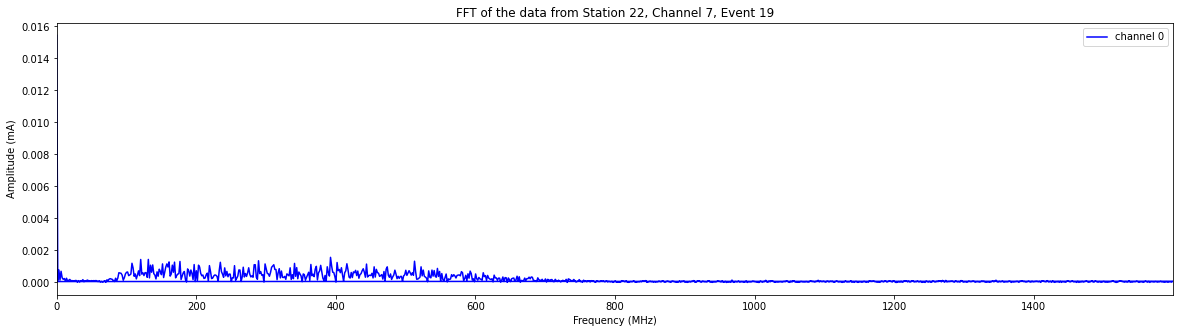

In [13]:
plt.figure(figsize=(20,5)) #visualization 
plt.plot(Vfreq*(10**-6),(2/len(VSamplingTimes))*np.abs(VFFT),'-',color='b', label="channel 0") #Convert freq to MHz
plt.title("FFT of the data from Station 22, Channel 7, Event 19")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Amplitude (mA)")
plt.xlim(0,np.max(Vfreq*(10**-6)))
plt.legend()
plt.show()

Plotted to visualize its alikeness with the amplifier response:

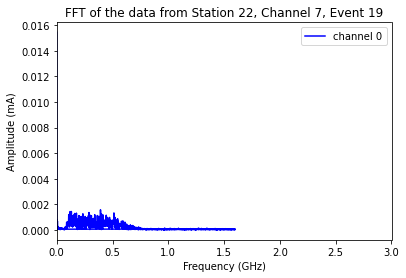

In [14]:
plt.figure()#figsize=(20,5)) #visualization 
plt.plot(Vfreq*(10**-9),(2/len(VSamplingTimes))*np.abs(VFFT),'-',color='b', label="channel 0") #Convert freq to MHz
plt.title("FFT of the data from Station 22, Channel 7, Event 19")
plt.xlabel("Frequency (GHz)")
plt.ylabel("Amplitude (mA)")
plt.xlim(0,3)#np.max(Vfreq*(10**-9)))
plt.legend()
plt.show()

Compute amplifier response:

Amplifier type is: iglu


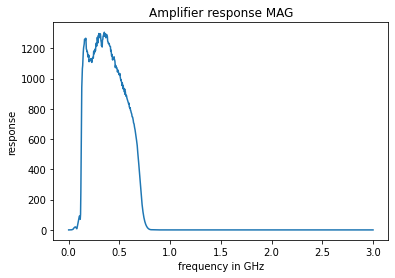

In [15]:
from NuRadioReco.detector import detector
from NuRadioReco.utilities import units
import datetime

det = detector.Detector(json_filename = "/mnt/c/Users/Jethro/AppData/Roaming/Microsoft/Windows/Start Menu/Programs/Python 3.8/NuRadioMC/NuRadioReco/detector/RNO_G/RNO_season_2021.json")
det.update(datetime.datetime(2022, 10, 1)) #date in example

station_id=22
channel_id=7
frequencies=np.linspace(0,3*units.GHz, 1000) #np.arange(10**6,10**8,500)#np.arange(4996000,70930000,10000)

print("Amplifier type is: " + det.get_amplifier_type(station_id,channel_id))

ResponseMag=np.abs(det.get_amplifier_response(station_id, channel_id, frequencies))

#print("Response MAG is: " + str(np.abs(det.get_amplifier_response(station_id, channel_id, frequencies))))

plt.figure()#figsize=(20,5))
plt.plot(frequencies,ResponseMag,'-')#, label="Channel " + str(ChNr))
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title("Amplifier response MAG")
#plt.ylim(-50,50)
#plt.xlim(0,np.max(SamplingTimes*(10**9)))
plt.ylabel("response")
plt.xlabel("frequency in GHz")
#plt.yscale('log')
#plt.legend()
plt.show()

from NuRadioReco.detector.RNO_G import analog_components as ac
responsefunctions=ac.load_amp_response("iglu", path="/mnt/c/Users/Jethro/AppData/Roaming/Microsoft/Windows/Start Menu/Programs/Python 3.8/NuRadioMC/NuRadioReco/detector/RNO_G")

#print("gain is: " + str(responsefunctions['gain'](frequencies)))
#print("phase is: " + str(responsefunctions['phase'](frequencies)))

And for the same frequencies as the FFT of the timetrace:

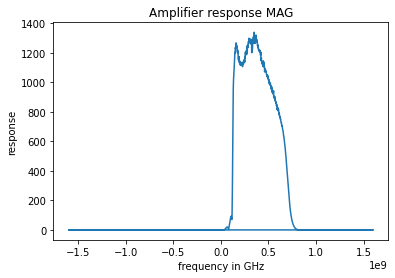

In [16]:
#det = detector.Detector(json_filename = "/mnt/c/Users/Jethro/AppData/Roaming/Microsoft/Windows/Start Menu/Programs/Python 3.8/NuRadioMC/NuRadioReco/detector/RNO_G/RNO_season_2021.json")
#det.update(datetime.datetime(2022, 10, 1)) #date in example

#station_id=22
#channel_id=7
#frequencies=np.linspace(0,3*units.GHz, 1000) #np.arange(10**6,10**8,500)#np.arange(4996000,70930000,10000)

#print("Amplifier type is: " + det.get_amplifier_type(station_id,channel_id))

#print("Response MAG is: " + str(np.abs(det.get_amplifier_response(station_id, channel_id, frequencies))))

VFreqResponseMag=np.abs(det.get_amplifier_response(station_id, channel_id, Vfreq*units.Hz))

plt.figure()#figsize=(20,5))
plt.plot(Vfreq,VFreqResponseMag,'-')#, label="Channel " + str(ChNr))
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title("Amplifier response MAG")
#plt.ylim(-50,50)
#plt.xlim(0,np.max(SamplingTimes*(10**9)))
plt.ylabel("response")
plt.xlabel("frequency in GHz")
#plt.yscale('log')
#plt.legend()
plt.show()

#from NuRadioReco.detector.RNO_G import analog_components as ac
#responsefunctions=ac.load_amp_response("iglu", path="/mnt/c/Users/Jethro/AppData/Roaming/Microsoft/Windows/Start Menu/Programs/Python 3.8/NuRadioMC/NuRadioReco/detector/RNO_G")

#print("gain is: " + str(responsefunctions['gain'](frequencies)))
#print("phase is: " + str(responsefunctions['phase'](frequencies)))

Figure out where the response magnitude is zero:

In [17]:
if ResponseMag[0]>0:
    lowfreq=0
#highfreq=0
for i in range(1,len(frequencies)):
    if ResponseMag[i]>0 and ResponseMag[i-1]==0:
        lowfreq=frequencies[i]
        lowfreqidx=i
    elif ResponseMag[i]==0 and ResponseMag[i-1]>0:
        highfreq=frequencies[i]
        highfreqidx=i
        
print(r"lowfreq= %1.2f"%(lowfreq) + "\n" +  r"highfreq= %1.2f"%(highfreq))

lowfreq= 0.00
highfreq= 1.00


In [18]:
ResponseMag[333] #Nonzero border index

0.015575160495248262

In [19]:
frequencies[333] #=> dit is in GHz

1.0

In [20]:
print(Vfreq[260], np.abs(VFFT[260]), VFreqResponseMag[260], np.abs(VFFT[260])/VFreqResponseMag[260])

406448461.1626771 0.6264061146868787 1206.7825524355562 0.0005190712389921875


In [21]:
VPreAmpFFT=np.array([ VFFT[i]/VFreqResponseMag[i] if VFreqResponseMag[i]!=0 else 0 for i in range(len(VFFT)) ])

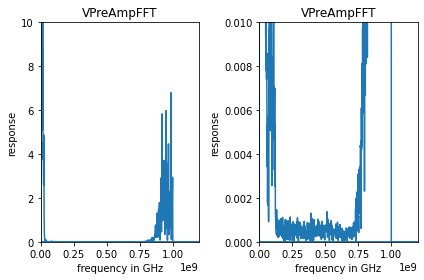

In [22]:
plt.figure()#figsize=(20,5))
#plt.plot(Vfreq,VFreqResponseMag,'-')#, label="Channel " + str(ChNr))
plt.subplot(121)
plt.plot(Vfreq,np.abs(VPreAmpFFT),'-')#, label="Channel " + str(ChNr))
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title("VPreAmpFFT")
plt.ylim(0,10)
#plt.xlim(0,np.max(SamplingTimes*(10**9)))
plt.xlim(0,1.2*10**9)
plt.ylabel("response")
plt.xlabel("frequency in GHz")
#plt.yscale('log')
#plt.legend()

plt.subplot(122)
plt.plot(Vfreq,np.abs(VPreAmpFFT),'-')#, label="Channel " + str(ChNr))
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title("VPreAmpFFT")
plt.ylim(0,10**-2)
#plt.xlim(0,np.max(SamplingTimes*(10**9)))
plt.xlim(0,1.2*10**9)
plt.ylabel("response")
plt.xlabel("frequency in GHz")
plt.tight_layout()
plt.show()

In [23]:
VPreAmp=scfft.ifft(VPreAmpFFT)
#for V in VPreAmp:
#    print(V)

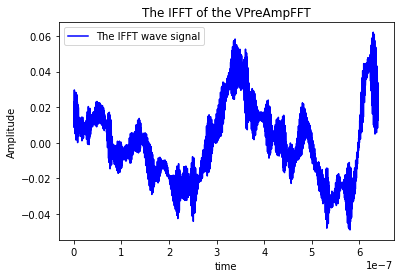

In [24]:
plt.figure() #visualization 
plt.plot(VSamplingTimes,np.real(VPreAmp),'-',color='b', label="The IFFT wave signal")
plt.title("The IFFT of the VPreAmpFFT")
plt.xlabel("time")
plt.ylabel("Amplitude")
#plt.xlim(0,np.max())
plt.legend()
#plt.ylim(-0.5*10**-5,0.5*10**-5)
#plt.savefig("Comparison_Euler_and_RK4_and_analytical")
plt.show()

As expected, the FFT starts to blow up once the response goes to zero => introduce some cut-off

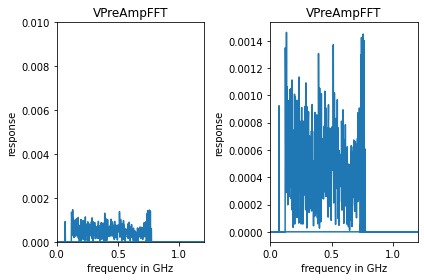

In [25]:
VPreAmpFFTCutOff=[V if np.abs(V) <0.0015 else 0 for V in VPreAmpFFT ]

plt.figure()#figsize=(20,5))
plt.subplot(121)
#plt.plot(Vfreq,VFreqResponseMag,'-')#, label="Channel " + str(ChNr))
plt.plot(Vfreq*10**-9,np.abs(VPreAmpFFTCutOff),'-')#, label="Channel " + str(ChNr))
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title("VPreAmpFFT")
plt.ylim(0,10**-2)
#plt.xlim(0,np.max(SamplingTimes*(10**9)))
plt.xlim(0,1.2)
plt.ylabel("response")
plt.xlabel("frequency in GHz")
#plt.yscale('log')
#plt.legend()

plt.subplot(122)
#plt.plot(Vfreq,VFreqResponseMag,'-')#, label="Channel " + str(ChNr))
plt.plot(Vfreq*10**-9,np.abs(VPreAmpFFTCutOff),'-')#, label="Channel " + str(ChNr))
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title("VPreAmpFFT")
#plt.ylim(0,10**-2)
#plt.xlim(0,np.max(SamplingTimes*(10**9)))
plt.xlim(0,1.2)
plt.ylabel("response")
plt.xlabel("frequency in GHz")
#plt.yscale('log')
#plt.legend()
plt.tight_layout()
plt.show()

In [26]:
VPreAmp=scfft.ifft(VPreAmpFFTCutOff)
for V in VPreAmp:
    print(V)

(1.3493385140970883e-07+8.27153200071946e-06j)
(-5.95820038411363e-06+7.143826056810653e-06j)
(-9.405028530131529e-06+9.587882721820063e-07j)
(-6.525887768957969e-06-5.628367149814089e-06j)
(-7.851752583818454e-08-6.984059755199813e-06j)
(3.881600044894856e-06-3.094982027843929e-06j)
(2.88888121160478e-06+1.2601655850176778e-06j)
(-6.534942819557904e-07+2.401741595532131e-06j)
(-3.423754573451804e-06+1.7662555539839028e-07j)
(-3.395894654028939e-06-3.844944934742116e-06j)
(4.582791489182109e-07-7.116400937507166e-06j)
(6.7840134976450045e-06-6.033871472512747e-06j)
(1.0492679582158763e-05+7.638506764758218e-07j)
(6.889923849680889e-06+8.648752431348418e-06j)
(-1.891976732284828e-06+1.0360525924054231e-05j)
(-7.970300871503445e-06+4.406126300961109e-06j)
(-6.599417484400587e-06-2.9210145851268656e-06j)
(-1.0892603826336263e-06-5.2646995601272445e-06j)
(2.5795045834609255e-06-2.9560494847902048e-06j)
(2.9120667971222736e-06-2.8184954012346874e-07j)
(2.3281998010401917e-06+8.9411383129850

This is complex in value -> I'd expect it to be real?

In [27]:
print(len(VPreAmp))

2048


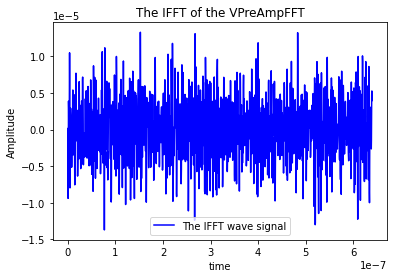

In [28]:
plt.figure() #visualization 
plt.plot(VSamplingTimes,np.real(VPreAmp),'-',color='b', label="The IFFT wave signal")
plt.title("The IFFT of the VPreAmpFFT")
plt.xlabel("time")
plt.ylabel("Amplitude")
#plt.xlim(0,np.max())
plt.legend()
#plt.savefig("Comparison_Euler_and_RK4_and_analytical")
plt.show()

### Now that we have the voltages all we need is a way to extract the temperature out of this

#### Obtain Power spectrum:

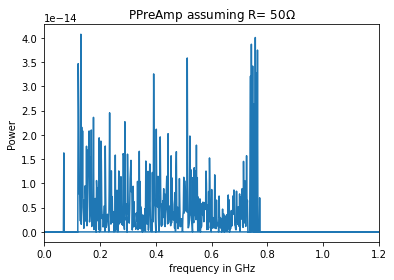

In [29]:
R=50
PPreAmp=[((V*(2/len(VSamplingTimes)))**2)/R for V in np.abs(VPreAmpFFTCutOff) ]

plt.figure()#figsize=(20,5))
#plt.plot(Vfreq,VFreqResponseMag,'-')#, label="Channel " + str(ChNr))
plt.plot(Vfreq*(10**-9),np.abs(PPreAmp),'-')#, label="Channel " + str(ChNr))
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title("PPreAmp assuming R= " + str(R) + r"$\Omega$")
#plt.ylim(0,10**-2)
#plt.xlim(0,np.max(SamplingTimes*(10**9)))
plt.xlim(0,1.2)
plt.ylabel("Power")
plt.xlabel("frequency in GHz")
#plt.yscale('log')
#plt.legend()
plt.show()

Resulting in a total power of: <br>
(Integrate over power distribution)

In [30]:
df=Vfreq[1]-Vfreq[0]
Ptot=np.sum(np.abs(PPreAmp))
print(Ptot)

2.4991618070501503e-12


#### Method 1:

R=50 $\Omega$ and P=$V^2$/R <br>
This yields Noise power per frequency => fit black body radiation to this to extract temperature

#### Method 2:

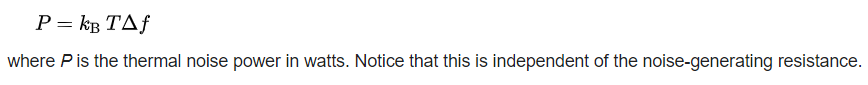

In [31]:
kb=1.38064852 * (10**(-23))
print(kb)

1.38064852e-23


For $\Delta$f choose the bandwith of the introduced cutoff <br>
So first compute this bandwidth:

Check for consistency with previous finding: <br>
(consistency check => doesn't work well with cutoff = 0)

def CutoffFreq(Threshold,Distr,Freq):
    """
    Computes the lower and higher frequency (and their indices in the Freq range) of a cutoff introduced at a value of Threshold for a certain distribution Distr over a frequency range Freq.
    --------
    Parameters:
    Threshold= The introduced threshold value for the cutoff.
    Distr = The distribution on which the cutoff is applied.
    Freq= The frequency range over which the distribution Distr is used.
    """
    lowfreq=-1
    highfreq=-1
    #highfreq=0
    for i in range(1,len(Freq)):
        if Distr[i]<=Threshold and Distr[i-1]>=Threshold and highfreq==-1 and lowfreq==-1:
            lowfreq=Freq[i]
            lowfreqidx=i
        if Distr[i]>=Threshold and Distr[i-1]<=Threshold and lowfreq!=-1:
            highfreq=Freq[i]
            highfreqidx=i
            
    return lowfreq,highfreq,lowfreqidx, highfreqidx

In [32]:
lowfreqtest,highfreqtest,lowfreqidxtest, highfreqidxtest=CutoffFreq(0,ResponseMag,frequencies)
print(r"lowfreq= %1.2f"%(lowfreqtest) + "\n" +  r"highfreq= %1.2f"%(highfreqtest))

lowfreq= 1.00
highfreq= 3.00


In [33]:
lowfreqCutoff,highfreqCutoff,lowfreqidxCutoff, highfreqidxCutoff=CutoffFreq(0.0015,np.abs(VPreAmpFFT),Vfreq)#np.abs(VPreAmpFFT[50:]),Vfreq[50:])
print(r"lowfreq= %1.2f"%(lowfreqCutoff*(10**-9)) + " GHz \n" +  r"highfreq= %1.2f"%(highfreqCutoff*10**-9) + " GHz")

lowfreq= 0.07 GHz 
highfreq= 0.77 GHz


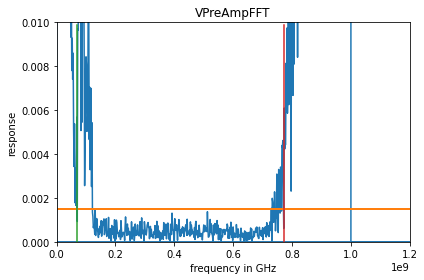

In [34]:
plt.figure()
Yval=np.arange(0,0.01,0.0001)
plt.plot(Vfreq,np.abs(VPreAmpFFT),'-')#, label="Channel " + str(ChNr))
plt.plot(Vfreq,0.0015*np.ones(len(Vfreq)),'-')
plt.plot(lowfreqCutoff/units.GHz*np.ones(len(Yval)),Yval,'-')
plt.plot(highfreqCutoff/units.GHz*np.ones(len(Yval)),Yval,'-')
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title("VPreAmpFFT")
plt.ylim(0,10**-2)
#plt.xlim(0,np.max(SamplingTimes*(10**9)))
plt.xlim(0,1.2*10**9)
plt.ylabel("response")
plt.xlabel("frequency in GHz")
plt.tight_layout()
plt.show()

Code finds cutoff frequencies well

Alternative Cutoff finder

def CutoffFreqMid(Threshold,Distr,InitRegion,Freq,NrStd=-1):
    """
    Computes the lower and higher frequency (and their indices in the Freq range) of a cutoff introduced at a value of Threshold starting from the middle for a certain distribution Distr over a frequency range Freq.
    --------
    Parameters:
    Threshold= The introduced threshold value for the cutoff.
    Distr = The distribution on which the cutoff is applied.
    InitRegion= region of frequencies of the form [lower frequency bound, upper frequency bound] from which the threshold is computed and extended 
    Freq= The frequency range over which the distribution Distr is used.
    """
    
    InitRegionIdx=[i  for i in range(len(Freq)) if InitRegion[0]<Freq[i]<InitRegion[1]]
    MidValIdx=InitRegionIdx[int(len(InitRegionIdx)/2)]
    
    if NrStd>0:
        Median=np.median([Distr[i]  for i in InitRegionIdx])
        Std=np.std([Distr[i]  for i in InitRegionIdx]) 
        Threshold=Median + NrStd*Std
        #print("The median, Std and resulting Threshold of InitRegion are " )
        #print(Median,Std,Threshold)
    lowfreqidx=MidValIdx
    while Distr[lowfreqidx]<Threshold or Distr[lowfreqidx-1]<Threshold:
        lowfreqidx-=1
    
    lowfreqidx+=1
    highfreqidx=MidValIdx
    while Distr[highfreqidx]<Threshold or Distr[highfreqidx+1]<Threshold:
        highfreqidx+=1
    
    highfreqidx-=1
    
    lowfreq, highfreq = Freq[lowfreqidx], Freq[highfreqidx]
            
    return lowfreq,highfreq,lowfreqidx, highfreqidx

In [35]:
ResponseMagAbove1000Idx=[i  for i in range(len(Vfreq)) if VFreqResponseMag[i]>1000]#filter(lambda i: VFreqResponseMag[i]>1000, range(len(Vfreq)))
InitRegionSt22R101Ch7=[Vfreq[min(ResponseMagAbove1000Idx)],Vfreq[max(ResponseMagAbove1000Idx)]]
lowfreqCutoffMid,highfreqCutoffMid,lowfreqidxCutoffMid, highfreqidxCutoffMid=CutoffFreqMid(0.0015,np.abs(VPreAmpFFT),InitRegionSt22R101Ch7,Vfreq)#Vfreq[50:])
print(r"lowfreq= %1.2f"%(lowfreqCutoffMid*(10**-9)) + " GHz \n" +  r"highfreq= %1.2f"%(highfreqCutoffMid*10**-9) + " GHz")

lowfreq= 0.12 GHz 
highfreq= 0.73 GHz


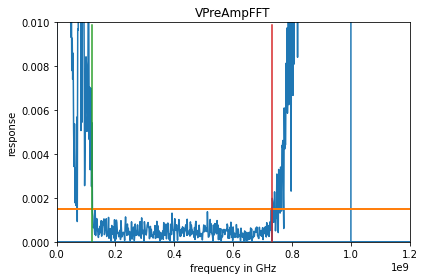

In [36]:
plt.figure()
Yval=np.arange(0,0.01,0.0001)
plt.plot(Vfreq,np.abs(VPreAmpFFT),'-')#, label="Channel " + str(ChNr))
plt.plot(Vfreq,0.0015*np.ones(len(Vfreq)),'-')
plt.plot(lowfreqCutoffMid/units.GHz*np.ones(len(Yval)),Yval,'-')
plt.plot(highfreqCutoffMid/units.GHz*np.ones(len(Yval)),Yval,'-')
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title("VPreAmpFFT")
plt.ylim(0,10**-2)
#plt.xlim(0,np.max(SamplingTimes*(10**9)))
plt.xlim(0,1.2*10**9)
plt.ylabel("response")
plt.xlabel("frequency in GHz")
plt.tight_layout()
plt.show()

This works better

In [37]:
print((highfreqCutoffMid-lowfreqCutoffMid)*10**-9)

0.6096726917440156


In [38]:
T3=Ptot/(kb*(highfreqCutoffMid-lowfreqCutoffMid))
print(str(T3) +" deg Kelvin, which is " + str(T3-273.15) + " deg Celcius")

296.90294188285037 deg Kelvin, which is 23.752941882850394 deg Celcius


Comparing this with Grafana temperature: <br>
(analog (controller board), remote_1 (RADIANT), remote_2) <br>
(avinngaq is on station 22, nanoq is on station 11 and amaroq is on station 21)

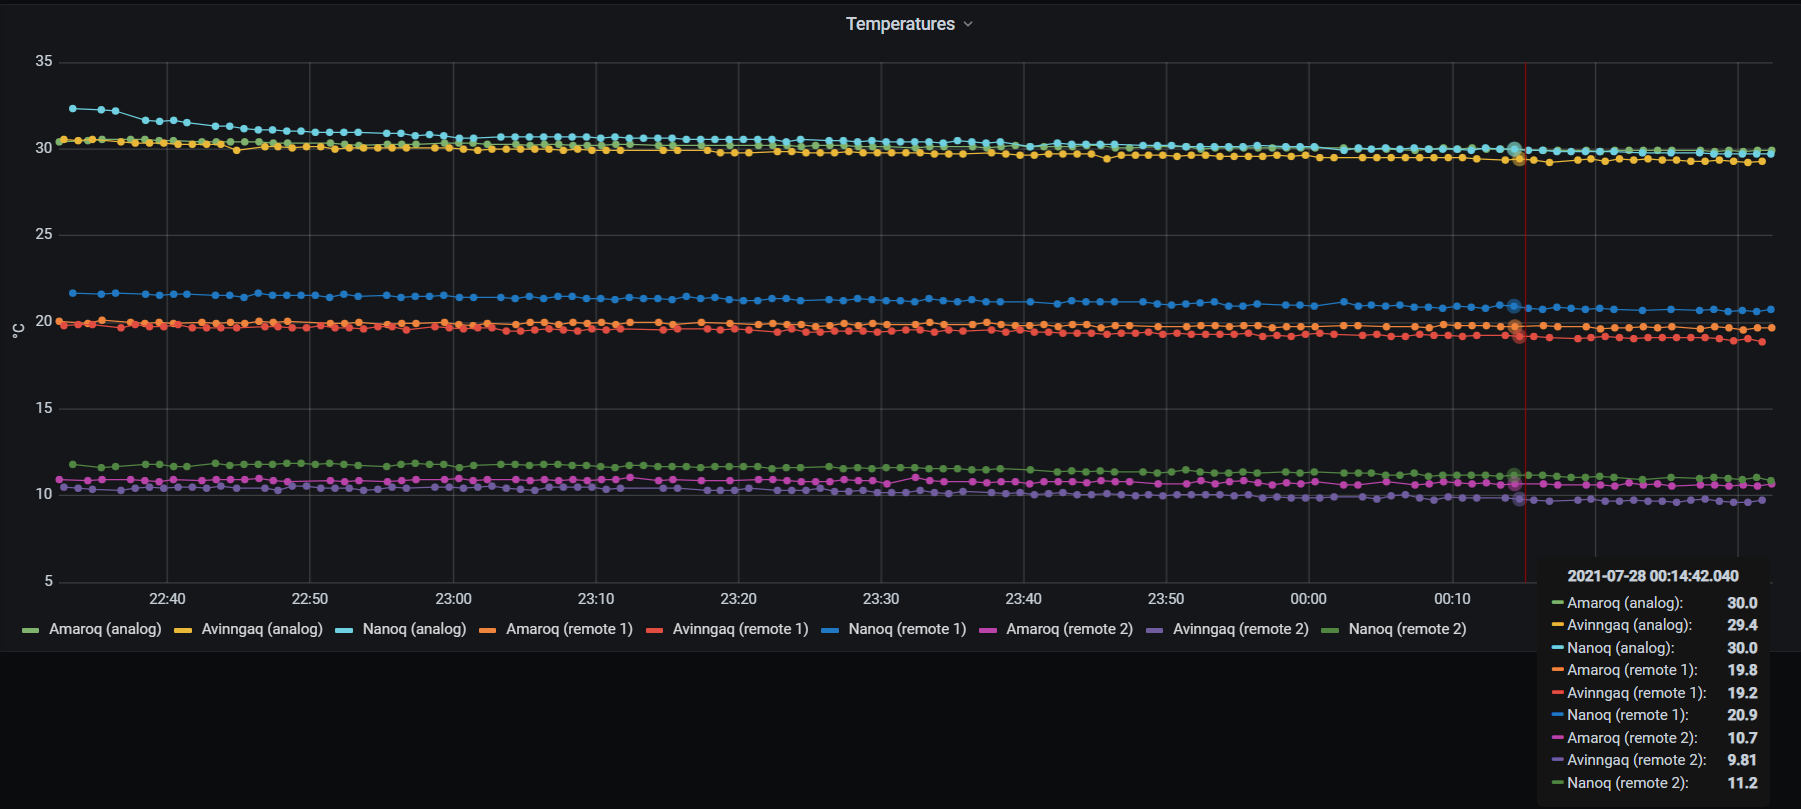

#### Automate this process:

def ThermalNoiseTemp(StNr,Runs,ChNr,DateStr,Debug=False):
    """DateStr= string of the form YYYYMMDD"""
    #Import the ADC count data
    ADCData=np.array([])
    NRuns=0
    for Run in Runs:
        path=Path(StNr,Run)
        #if os.path.isdir(path+"/combined.root"):
        if os.path.isfile(path+"/combined.root"):
            
            NRuns+=1
            
            CombinedFile, DAQStatFile, HeadersFile, PedestalFile=FilesStRun(StNr,Run)
            RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
            EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")
            PedestalData=PedestalFile['']['pedestals[24][4096]'].array(library='np')
            StartWindow = np.array(CombinedFile['combined']['header/trigger_info/trigger_info.radiant_info.start_windows[24][2]'])
            
            for EvIdx in range(RadiantData.shape[0]):
                EvNr=EventNrs[EvIdx]
                #for ChNr in ChNrs:
                ADCData=np.append(ADCData,RadiantData[EvIdx][ChNr][:])
    
    if len(ADCData)==0:
        return None
    
    #Convert to voltages
    VData=ADCtoVoltage(ADCData)
    
    #Fourier transform the signal
    sampling_rate=3.2 * (10**9) #Sampling rate in Hertz according to the python file of NuRadioReco.modules.io.rno_g
    TimeStep=1/sampling_rate #Time between two samples
    VSamplingTimes=np.arange(0,len(VData),1)*TimeStep
    
    VFFT=scfft.fft(VData)
    Vfreq=scfft.fftfreq(len(VSamplingTimes),(VSamplingTimes[-1]-VSamplingTimes[0])/len(VSamplingTimes))
    
    #Obtain amplifier response
    det = detector.Detector(json_filename = "/mnt/c/Users/Jethro/AppData/Roaming/Microsoft/Windows/Start Menu/Programs/Python 3.8/NuRadioMC/NuRadioReco/detector/RNO_G/RNO_season_2021.json")
    det.update(datetime.datetime(int(DateStr[:4]), int(DateStr[4:6]), int(DateStr[6:]))) #date in example
    ResponseMag=np.abs(det.get_amplifier_response(StNr, ChNr, Vfreq*units.Hz))
               
    #Divide by amplifier response
    VPreAmpFFT=np.array([ VFFT[i]/ResponseMag[i] if ResponseMag[i]!=0 else 0 for i in range(0,len(VFFT)) ])
               
    #Cutoff the resulting FFT

    ##Expect the region where the amplification factir is above 1000 to be realistic and a valid base for starting the search of the cutoff frequency region
    ResponseMagAbove1000Idx=[i  for i in range(len(Vfreq)) if ResponseMag[i]>1000]
    InitRegion=[Vfreq[min(ResponseMagAbove1000Idx)],Vfreq[max(ResponseMagAbove1000Idx)]]
    
    Threshold=0.0015
    lowfreqCutoff,highfreqCutoff,lowfreqidxCutoff, highfreqidxCutoff=CutoffFreqMid(Threshold,np.abs(VPreAmpFFT),InitRegion,Vfreq,NrStd=7)
    VPreAmpFFTCutOff=[VPreAmpFFT[i] if lowfreqidxCutoff < i < highfreqidxCutoff else 0 for i in range(len(VPreAmpFFT)) ]
               
    #Obtain power spectrum from this
    R=50
    PPreAmp=[((V*(2/len(VSamplingTimes)))**2)/R for V in np.abs(VPreAmpFFTCutOff) ]
    
    Ptot=np.sum(np.abs(PPreAmp)) #Total power of the spectrum
    
    kb=1.38064852 * (10**(-23)) #Boltzmann constant
    TempThermal=Ptot/(kb*(highfreqCutoff-lowfreqCutoff))#Associated temerature
    
    if Debug:
        Yval=np.arange(0,1400,1)
        plt.figure(figsize=(20,5))
        plt.plot(Vfreq*10**-9,ResponseMag,'-')#, label="Channel " + str(ChNr))
        plt.plot(lowfreqCutoff*10**-9*np.ones(len(Yval)),Yval,'-')
        plt.plot(highfreqCutoff*10**-9*np.ones(len(Yval)),Yval,'-')
        #plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
        plt.title("Amplifier response MAG")
        #plt.ylim(-50,50)
        #plt.xlim(0,np.max(SamplingTimes*(10**9)))
        plt.xlim(0,1.2)
        plt.ylabel("response")
        plt.xlabel("frequency in GHz")
        #plt.yscale('log')
        #plt.legend()
        plt.show()
        
        
        print("Ptot=" + str(Ptot))
        print("Bandwidth=" + str((highfreqCutoff-lowfreqCutoff)*10**-9) + " GHz")
        print("lowfreqcutoff, highfreqcutoff in GHz is:")
        print(lowfreqCutoff*10**-9,highfreqCutoff*10**-9)
        print("InitRegion in GHz is:")
        print([F*(10**-9) for F in InitRegion])
        plt.figure(figsize=(20,5))
        #plt.plot(Vfreq,VFreqResponseMag,'.')#, label="Channel " + str(ChNr))
        plt.plot(Vfreq*10**-9,np.abs(VPreAmpFFT),'.')#, label="Channel " + str(ChNr))
        plt.plot(lowfreqCutoff*10**-9*np.ones(len(Yval)),Yval,'-')
        plt.plot(highfreqCutoff*10**-9*np.ones(len(Yval)),Yval,'-')
        #plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
        plt.title("VPreAmpFFT")
        plt.ylim(0,10)
        #plt.xlim(0,np.max(SamplingTimes*(10**9)))
        plt.xlim(0,1.2)
        plt.ylabel("response")
        plt.xlabel("frequency in GHz")
        #plt.yscale('log')
        #plt.legend()
        plt.show()

        plt.figure(figsize=(20,5))
        plt.plot(Vfreq*10**-9,np.abs(VPreAmpFFT),'.')#, label="Channel " + str(ChNr))
        plt.plot(lowfreqCutoff*10**-9*np.ones(len(Yval)),Yval,'-')
        plt.plot(highfreqCutoff*10**-9*np.ones(len(Yval)),Yval,'-')
        #plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
        plt.title("VPreAmpFFT")
        plt.ylim(0,20*10**-2)
        #plt.xlim(0,np.max(SamplingTimes*(10**9)))
        plt.xlim(0,1.2)
        plt.ylabel("response")
        plt.xlabel("frequency in GHz")
        plt.tight_layout()
        plt.show()
        
        print("Maximal value in VPreAmpFFTCutOff is")
        print(np.max(np.abs(VPreAmpFFTCutOff)))
        
        plt.figure(figsize=(20,5))
        #plt.plot(Vfreq,VFreqResponseMag,'.')#, label="Channel " + str(ChNr))
        plt.plot(Vfreq*10**-9,np.abs(VPreAmpFFTCutOff),'.')#, label="Channel " + str(ChNr))
        #plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
        plt.title("VPreAmpFFT")
        plt.ylim(0,10)
        #plt.xlim(0,np.max(SamplingTimes*(10**9)))
        plt.xlim(0,1.2)
        plt.ylabel("response")
        plt.xlabel("frequency in GHz")
        #plt.yscale('log')
        #plt.legend()
        plt.show()

        plt.figure(figsize=(20,5))
        plt.plot(Vfreq*10**-9,np.abs(VPreAmpFFTCutOff),'.')#, label="Channel " + str(ChNr))
        #plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
        plt.title("VPreAmpFFT")
        plt.ylim(0,20*10**-2)
        #plt.xlim(0,np.max(SamplingTimes*(10**9)))
        plt.xlim(0,1.2)
        plt.ylabel("response")
        plt.xlabel("frequency in GHz")
        plt.tight_layout()
        plt.show()
        
            
    return TempThermal

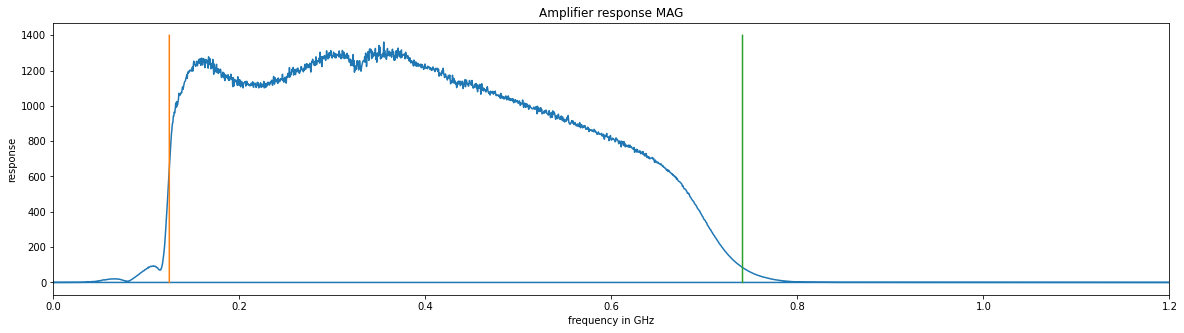

Ptot=2.40099004931853e-12
Bandwidth=0.6163404754661435 GHz
lowfreqcutoff, highfreqcutoff in GHz is:
0.1245823639874848 0.7409228394536282
InitRegion in GHz is:
[0.13118765869452956, 0.5121479914463171]


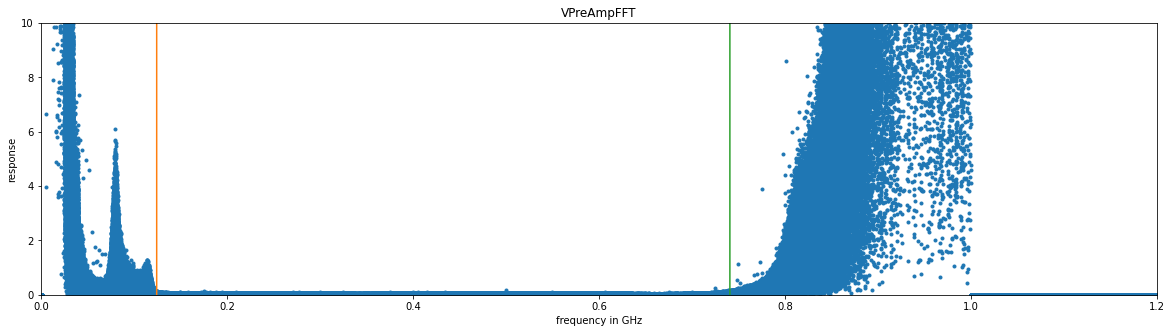

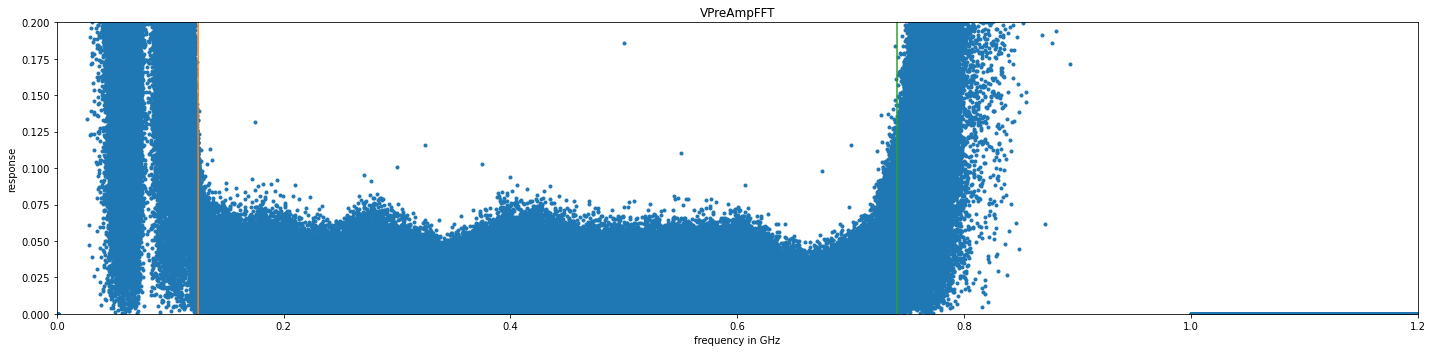

Maximal value in VPreAmpFFTCutOff is
0.2644523278056638


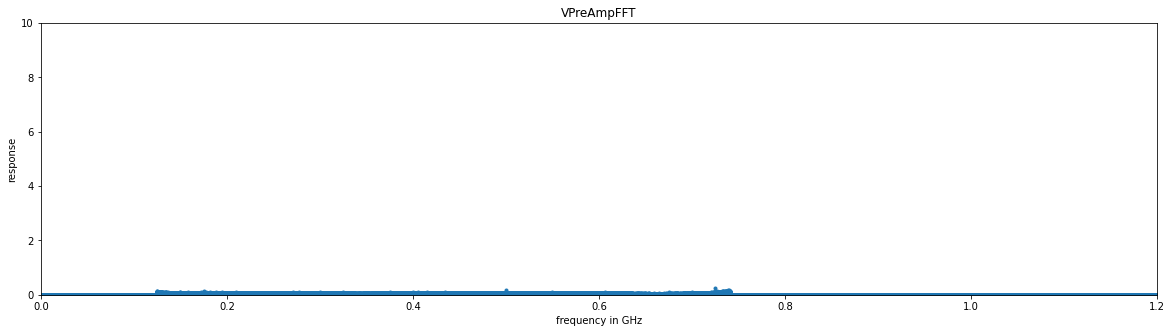

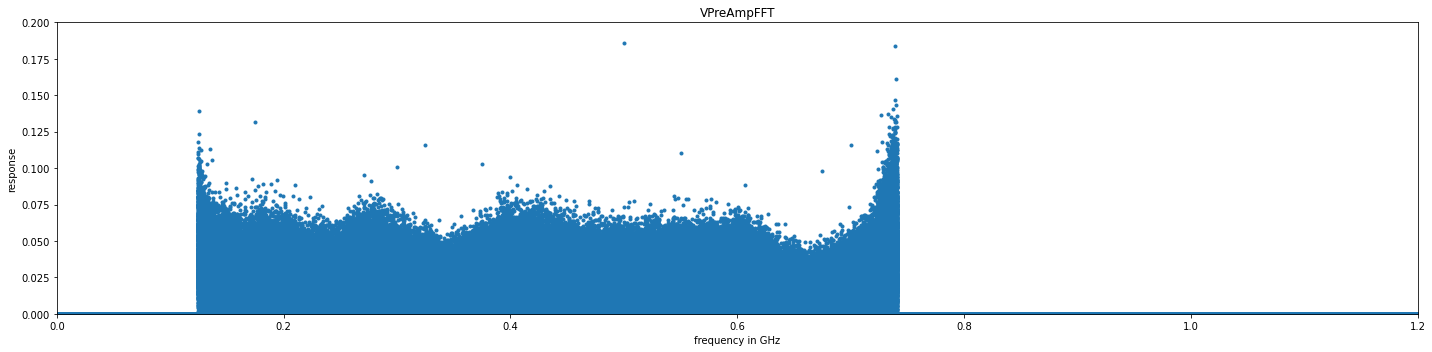

282.15421304800265

In [39]:
ThermalNoiseTemp(22,[101],7,"20221001",Debug=True)

Compute this for many runs in order to obtain a mean and a standard deviation

In [40]:
Runs=np.arange(91,111)
Temps=np.array([])
for Run in Runs:
    T=ThermalNoiseTemp(22,[Run],7,"20221001")
    if T != None:
        Temps=np.append(Temps,ThermalNoiseTemp(22,[Run],7,"20221001"))
print("The temperature is " + str(np.round(np.mean(Temps),2)) + u" \u00B1 " + str(np.round(np.std(Temps),2)) + " \u00B0K")
print("Which is some " + str(np.round(np.mean(Temps)- 273.15,2) ) + u" \u00B1 " + str(np.round(np.std(Temps),2)) + u" \u00B0C")

The temperature is 290.14 ± 14.72 °K
Which is some 16.99 ± 14.72 °C


#### Method : via electrical fields at the antenna

Obtain antenna effective heights

WARNING - NuRadioReco.antennapattern - loading antenna file bicone_v8_inf_n1.78 took 1 seconds
WARNING - NuRadioReco.antennapattern - loading antenna file bicone_v8_inf_n1.4 took 1 seconds
WARNING - NuRadioReco.antennapattern - loading antenna file bicone_v8_InfAir took 1 seconds
WARNING - NuRadioReco.antennapattern - loading antenna file XFDTD_Vpol_CrossFeed_150mmHole_n1.78 took 0 seconds


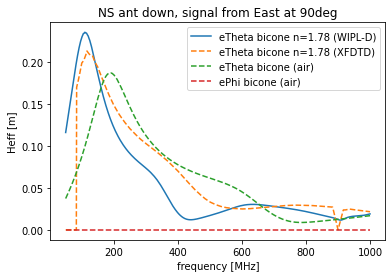

In [41]:
import NuRadioReco.detector.antennapattern
import matplotlib.pyplot as plt
from NuRadioReco.utilities import units
import logging
import numpy as np

from NuRadioReco.modules.base import module
logger = module.setup_logger(level=logging.DEBUG)

provider = NuRadioReco.detector.antennapattern.AntennaPatternProvider()

theta = 90 * units.deg
ff = np.linspace(50 * units.MHz, 1 * units.GHz, 1000)
bicone = provider.load_antenna_pattern("bicone_v8_inf_n1.78")
bicone_n14 = provider.load_antenna_pattern("bicone_v8_inf_n1.4")
bicone_air = provider.load_antenna_pattern("bicone_v8_InfAir")

bicone_XFDTD = provider.load_antenna_pattern("XFDTD_Vpol_CrossFeed_150mmHole_n1.78")


VELs = bicone.get_antenna_response_vectorized(ff, 90 * units.deg, np.deg2rad(0),
                                              np.deg2rad(180), 0, np.deg2rad(90), np.deg2rad(0))
fig, (ax) = plt.subplots(1, 1, sharey=True)
ax.plot(ff / units.MHz, np.abs(VELs['theta']), label='eTheta bicone n=1.78 (WIPL-D)')
# ax.plot(ff / units.MHz, np.abs(VELs['phi']), label='ePhi bicone (WIPL-D)')

VELs = bicone_XFDTD.get_antenna_response_vectorized(
    ff,
    90 * units.deg,
    np.deg2rad(0),
    np.deg2rad(180),
    0,
    np.deg2rad(90),
    np.deg2rad(0)
)

ax.plot(ff / units.MHz, np.abs(VELs['theta']), '--', label='eTheta bicone n=1.78 (XFDTD)')
# ax.plot(ff / units.MHz, np.abs(VELs['phi']), '--', label='ePhi bicone (old ARA)')

VELs = bicone_air.get_antenna_response_vectorized(ff, 90 * units.deg, np.deg2rad(0),
                                                  np.deg2rad(180), 0, np.deg2rad(90), np.deg2rad(0))
ax.plot(ff / units.MHz, np.abs(VELs['theta']), '--', label='eTheta bicone (air)')
ax.plot(ff / units.MHz, np.abs(VELs['phi']), '--', label='ePhi bicone (air)')

ax.set_title('NS ant down, signal from East at 90deg')
ax.legend()
ax.set_ylabel("Heff [m]")
ax.set_xlabel("frequency [MHz]")


plt.show()

For our RNO-G detectors:

In [42]:
Antenna_Type=det.get_antenna_type(station_id, channel_id)
print(Antenna_Type)

RNOG_vpol_4inch_center_n1.73


WARNING - NuRadioReco.antennapattern - no hash sum of RNOG_vpol_4inch_center_n1.73.pkl available, skipping up-to-date check
WARNING - NuRadioReco.antennapattern - no hash sum of RNOG_vpol_4inch_center_n1.73.pkl available, skipping up-to-date check
WARNING - NuRadioReco.antennapattern - loading antenna file RNOG_vpol_4inch_center_n1.73 took 0 seconds
WARNING - NuRadioReco.antennapattern - loading antenna file RNOG_vpol_4inch_center_n1.73 took 0 seconds
WARNING - NuRadioReco.antennapattern - loading antenna file createLPDA_100MHz_InfFirn_n1.4 took 11 seconds
WARNING - NuRadioReco.antennapattern - loading antenna file createLPDA_100MHz_InfFirn_n1.4 took 11 seconds
WARNING - NuRadioReco.antennapattern - no hash sum of RNOG_quadslot_v3_air_rescaled_to_n1.74.pkl available, skipping up-to-date check
WARNING - NuRadioReco.antennapattern - no hash sum of RNOG_quadslot_v3_air_rescaled_to_n1.74.pkl available, skipping up-to-date check
WARNING - NuRadioReco.antennapattern - loading antenna file RN

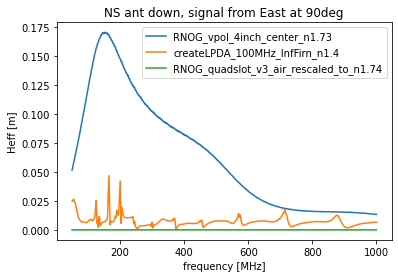

In [43]:
import NuRadioReco.detector.antennapattern
import matplotlib.pyplot as plt
from NuRadioReco.utilities import units
import logging
import numpy as np

from NuRadioReco.modules.base import module
logger = module.setup_logger(level=logging.DEBUG)

provider = NuRadioReco.detector.antennapattern.AntennaPatternProvider()

theta = 90 * units.deg
ff = np.linspace(50 * units.MHz, 1 * units.GHz, 1000)
#bicone = provider.load_antenna_pattern("bicone_v8_inf_n1.78")
#bicone_n14 = provider.load_antenna_pattern("bicone_v8_inf_n1.4")
#AntennaPattern = provider.load_antenna_pattern(Antenna_Type)
bicone_RNOG_Vpol = provider.load_antenna_pattern("RNOG_vpol_4inch_center_n1.73") #Name you get from det.get_antenna_type(station_id, channel_id) misses an "n"!
bicone_RNOG_LPDA = provider.load_antenna_pattern("createLPDA_100MHz_InfFirn_n1.4")
bicone_RNOG_quadslot = provider.load_antenna_pattern("RNOG_quadslot_v3_air_rescaled_to_n1.74")

#get_antenna_response_vectorized(self, freq, zenith, azimuth, orientation_theta, orientation_phi, rotation_theta, rotation_phi)
VELs = bicone_RNOG_Vpol.get_antenna_response_vectorized(ff, 90 * units.deg, np.deg2rad(0),
                                              np.deg2rad(180), 0, np.deg2rad(90), np.deg2rad(0))
fig, (ax) = plt.subplots(1, 1, sharey=True)
ax.plot(ff / units.MHz, np.abs(VELs['theta']), label='RNOG_vpol_4inch_center_n1.73')

VELs = bicone_RNOG_LPDA.get_antenna_response_vectorized(ff, 90 * units.deg, np.deg2rad(0),
                                              np.deg2rad(180), 0, np.deg2rad(90), np.deg2rad(0))

ax.plot(ff / units.MHz, np.abs(VELs['theta']), label='createLPDA_100MHz_InfFirn_n1.4')

VELs = bicone_RNOG_quadslot.get_antenna_response_vectorized(ff, 90 * units.deg, np.deg2rad(0),
                                              np.deg2rad(180), 0, np.deg2rad(90), np.deg2rad(0))

ax.plot(ff / units.MHz, np.abs(VELs['theta']), label='RNOG_quadslot_v3_air_rescaled_to_n1.74')

#print(np.abs(VELs['theta']))

ax.set_title('NS ant down, signal from East at 90deg')
ax.legend()
ax.set_ylabel("Heff [m]")
ax.set_xlabel("frequency [MHz]")


plt.show()

Compute the effective heights for the frequencies of the FFT:

In [44]:
VELs = bicone_RNOG_Vpol.get_antenna_response_vectorized(Vfreq*units.Hz, 90 * units.deg, np.deg2rad(0),
                                              np.deg2rad(180), 0, np.deg2rad(90), np.deg2rad(0))

And divide the frequency amplitudes by these values:

In [45]:
print(len(VPreAmpFFTCutOff),len(np.abs(VELs['theta'])),len(Vfreq))

2048 2048 2048


(-4.619728609480636e-05-3.0065458674638738e-05j) 0.02841935811811862


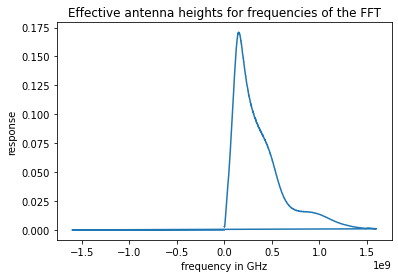

In [46]:
i=400
print(VPreAmpFFTCutOff[i],np.abs(VELs['theta'])[i])

plt.figure()#figsize=(20,5))
#plt.plot(Vfreq,VFreqResponseMag,'-')#, label="Channel " + str(ChNr))
#plt.plot(Vfreq,np.abs(VPreAmpFFTCutOff),'-')#, label="Channel " + str(ChNr))
plt.plot(Vfreq,np.abs(VELs['theta']),'-')#, label="Channel " + str(ChNr))
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title("Effective antenna heights for frequencies of the FFT")
#plt.ylim(0,10**-4)
#plt.xlim(0,np.max(SamplingTimes*(10**9)))
#plt.xlim(0,0.002*10**9)
#plt.xlim(-0.002*10**9,0.002*10**9)
plt.ylabel("response")
plt.xlabel("frequency in GHz")
#plt.yscale('log')
#plt.legend()
plt.show()

In [47]:
EAntennaFFT= np.array([ VPreAmpFFTCutOff[i]/np.abs(VELs['theta'])[i] if np.abs(VELs['theta'])[i]!=0 else 0 for i in range(len(Vfreq)) ])

In [48]:
print(np.abs(VELs['theta'])[1023])

0.0009794791653235818


Towards the 1.5 GHz, the effective height approached zero => another cutoff necessary to avoid  blowup?

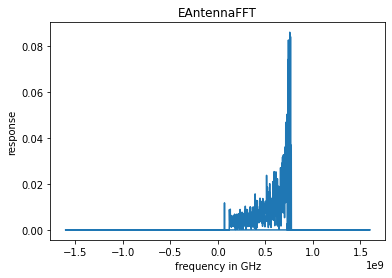

In [49]:
plt.figure()#figsize=(20,5))
#plt.plot(Vfreq,VFreqResponseMag,'-')#, label="Channel " + str(ChNr))
plt.plot(Vfreq,np.abs(EAntennaFFT),'-')#, label="Channel " + str(ChNr))
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title("EAntennaFFT")
#plt.ylim(0,10**-4)
#plt.xlim(0,np.max(SamplingTimes*(10**9)))
#plt.xlim(0,1.2*10**9)
plt.ylabel("response")
plt.xlabel("frequency in GHz")
#plt.yscale('log')
#plt.legend()
plt.show()

Visualisation of the associated waveform

In [50]:
EAntenna=scfft.ifft(EAntennaFFT)

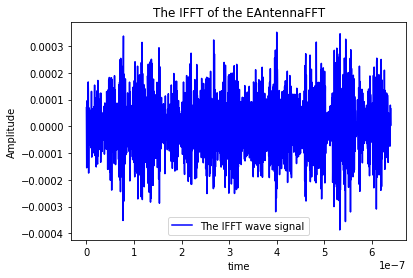

In [51]:
plt.figure() #visualization 
plt.plot(VSamplingTimes,np.real(EAntenna),'-',color='b', label="The IFFT wave signal")
plt.title("The IFFT of the EAntennaFFT")
plt.xlabel("time")
plt.ylabel("Amplitude")
#plt.xlim(0,np.max())
plt.legend()
#plt.savefig("Comparison_Euler_and_RK4_and_analytical")
plt.show()

Norm of Pointing vector |$\vec{S}$| = $\frac{c}{4 \pi} E^2$ <br>
Power is then given by P = $\int_{sphere}|\vec{S}| dA$ = $\frac{c}{4 \pi} \int_{\phi=0}^{2\pi} \int_{\theta=0}^{\pi} E^2 \cdot r  \cdot sin\theta \cdot r d\phi d\theta$ <br>

In [52]:
P_Noise=((ADCtoVoltage(FWHM))**2)/50
print("P_Noise= " + str(P_Noise) + " Watt")

P_Noise= 2.8866278087994497e-06 Watt


Don't know how to distill a single amplification factor from this (no knowledge of what frequency is used) => use median as a placeholder

## Questions

**Inverse fourier transform yields complex valued array for the waveform. How should I deal with this? (I expected only real values and so continued with the real component)**
 
 Answer: The result being complex is a purely mathematical result. Furthermore, the imaginary part can be reconstructed from the real part and their magnitudes are equal. For plotting purposes you can discard the imaginary part but when plotting the power do not forget to account for the contribution of the imaginary part!

**Second cut-off necessary at division by antenna height?**
 
 Answer:.

**Error propagation for temperature? (e.g. variance from inspecting multiple runs or extracting from approx made during computation or ...)**
 
 Answer:.

**Question**
 
 Answer:.